## Context

Often, it isn't possible to get the real data where we applied our analysis. In these cases, we can generate similar dataset that contain similar phenomena based on real data. This notebook shows an example about how we can do it.

## Get base data
The data, we want to derive another dataset. It's just there to get some realistic file names

In [1]:
from lib.ozapfdis import git_tc

log = git_tc.log_numstat("C:/dev/repos/buschmais-spring-petclinic")
log.head()

,additions,deletions,file,sha,timestamp,author
1,1,1,pom.xml,f96d80e,2018-06-12 08:32:28,Dirk Mahler
3,5,5,jqassistant/layer.adoc,d6e9509,2018-05-30 14:59:44,Dirk Mahler
5,1,1,jqassistant/layer.adoc,87b88d9,2018-05-18 22:43:32,Dirk Mahler
7,4,0,pom.xml,ebb50e0,2018-05-17 20:51:14,Dirk Mahler
9,1,1,jqassistant/index.adoc,b9b6dcf,2018-05-16 21:32:29,Dirk Mahler


In [2]:
log = log[log.file.str.contains(".java")]
log.loc[log.file.str.contains("/jdbc/"), 'type'] = "jdbc"
log.loc[log.file.str.contains("/jpa/"), 'type'] = "jpa"
log.loc[log.type.isna(), 'type'] = "other"
log.head()

,additions,deletions,file,sha,timestamp,author,type
234,4,5,src/test/java/org/springframework/samples/petc...,e525415,2016-08-19 16:54:56,Antoine Rey,other
235,25,7,src/test/java/org/springframework/samples/petc...,e525415,2016-08-19 16:54:56,Antoine Rey,other
236,21,9,src/test/java/org/springframework/samples/petc...,e525415,2016-08-19 16:54:56,Antoine Rey,other
237,23,3,src/test/java/org/springframework/samples/petc...,e525415,2016-08-19 16:54:56,Antoine Rey,other
238,10,6,src/test/java/org/springframework/samples/petc...,e525415,2016-08-19 16:54:56,Antoine Rey,other


## Create synthetic dataset 1
For the first technology, where "JDBC" was used.

### Create committed lines

In [3]:
import numpy as np
import pandas as pd

np.random.seed(0)
# adding period
added_lines = [int(np.random.normal(30,50)) for i in range(0,600)]
# deleting period
added_lines.extend([int(np.random.normal(-50,100)) for i in range(0,200)])
added_lines.extend([int(np.random.normal(-2,20)) for i in range(0,200)])
added_lines.extend([int(np.random.normal(-3,10)) for i in range(0,200)])
df_jdbc = pd.DataFrame()
df_jdbc['lines'] = added_lines
df_jdbc.head()

,lines
0,118
1,50
2,78
3,142
4,123


### Add timestamp

In [4]:
times = pd.timedelta_range("00:00:00","23:59:59", freq="s")
times = pd.Series(times)
times.head()

0   00:00:00
1   00:00:01
2   00:00:02
3   00:00:03
4   00:00:04
dtype: timedelta64[ns]

In [5]:
dates = pd.date_range('2013-05-15', '2017-07-23')
dates = pd.to_datetime(dates)
dates = dates[~dates.dayofweek.isin([5,6])]
dates = pd.Series(dates)
dates = dates.add(times.sample(len(dates), replace=True).values)
dates.head()

0   2013-05-15 03:35:33
1   2013-05-16 02:15:44
2   2013-05-17 15:12:26
3   2013-05-20 00:16:06
4   2013-05-21 17:43:53
dtype: datetime64[ns]

In [6]:
df_jdbc['timestamp'] = dates.sample(len(df_jdbc), replace=True).sort_values().reset_index(drop=True)
df_jdbc = df_jdbc.sort_index()
df_jdbc.head()

,lines,timestamp
0,118,2013-05-15 03:35:33
1,50,2013-05-16 02:15:44
2,78,2013-05-17 15:12:26
3,142,2013-05-24 05:52:31
4,123,2013-05-28 08:15:35


### Treat first commit separetely
Set a fixed value because we have to start with some code at the beginning

In [7]:
df_jdbc.loc[0, 'lines'] = 250
df_jdbc.head()

,lines,timestamp
0,250,2013-05-15 03:35:33
1,50,2013-05-16 02:15:44
2,78,2013-05-17 15:12:26
3,142,2013-05-24 05:52:31
4,123,2013-05-28 08:15:35


In [8]:
df_jdbc = df_jdbc

### Add file names
Sample file names including their paths from an existing dataset

In [9]:
df_jdbc['file'] = log[log['type'] == 'jdbc']['file'].sample(len(df_jdbc), replace=True).values

### Check dataset

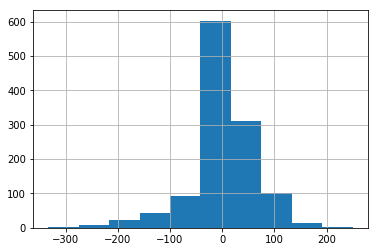

In [10]:
%matplotlib inline
df_jdbc.lines.hist()

Sum up the data and check if it was created as wanted.

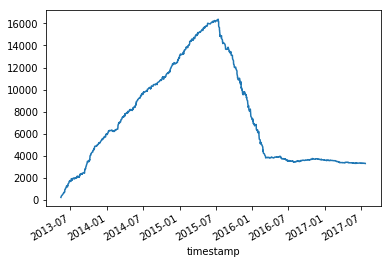

In [11]:
df_jdbc_timed = df_jdbc.set_index('timestamp')
df_jdbc_timed['count'] = df_jdbc_timed.lines.cumsum()
df_jdbc_timed['count'].plot()

In [12]:
last_non_zero_timestamp = df_jdbc_timed[df_jdbc_timed['count'] >= 0].index.max()
last_non_zero_timestamp

Timestamp('2017-07-21 19:02:47')

In [13]:
df_jdbc = df_jdbc[df_jdbc.timestamp <= last_non_zero_timestamp]
df_jdbc.head()

,lines,timestamp,file
0,250,2013-05-15 03:35:33,src/main/java/org/springframework/samples/petc...
1,50,2013-05-16 02:15:44,src/main/java/org/springframework/samples/petc...
2,78,2013-05-17 15:12:26,src/main/java/org/springframework/samples/petc...
3,142,2013-05-24 05:52:31,src/main/java/org/springframework/samples/petc...
4,123,2013-05-28 08:15:35,src/main/java/org/springframework/samples/petc...


## Create synthetic dataset 2

In [14]:
df_jpa = pd.DataFrame([int(np.random.normal(20,50)) for i in range(0,600)], columns=['lines'])
df_jpa.loc[0,'lines'] = 150
df_jpa['timestamp'] = pd.DateOffset(years=2) + dates.sample(len(df_jpa), replace=True).sort_values().reset_index(drop=True)
df_jpa = df_jpa.sort_index()
df_jpa['file'] = log[log['type'] == 'jpa']['file'].sample(len(df_jpa), replace=True).values
df_jpa.head()

,lines,timestamp,file
0,150,2015-05-17 15:12:26,src/main/java/org/springframework/samples/petc...
1,86,2015-05-20 00:16:06,src/main/java/org/springframework/samples/petc...
2,-27,2015-05-24 05:52:31,src/main/java/org/springframework/samples/petc...
3,14,2015-06-04 21:09:15,src/main/java/org/springframework/samples/petc...
4,66,2015-06-06 19:22:39,src/main/java/org/springframework/samples/petc...


### Check dataset

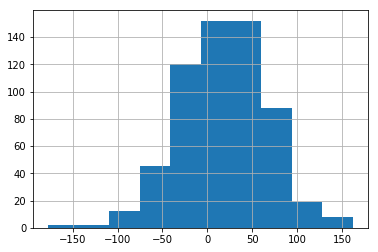

In [15]:
df_jpa.lines.hist()

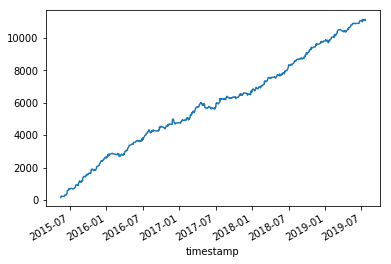

In [16]:
df_jpa_timed = df_jpa.set_index('timestamp')
df_jpa_timed['count'] = df_jpa_timed.lines.cumsum()
df_jpa_timed['count'].plot()

### Add some noise

In [17]:
dates_other = pd.date_range(df_jdbc.timestamp.min(), df_jpa.timestamp.max())
dates_other = pd.to_datetime(dates_other)
dates_other = dates_other[~dates_other.dayofweek.isin([5,6])]
dates_other = pd.Series(dates_other)
dates_other = dates_other.add(times.sample(len(dates_other), replace=True).values)
dates_other.head()

0   2013-05-15 17:36:46
1   2013-05-16 22:05:34
2   2013-05-17 19:27:07
3   2013-05-20 06:28:34
4   2013-05-21 03:46:00
dtype: datetime64[ns]

In [18]:
df_other = pd.DataFrame([int(np.random.normal(5,100)) for i in range(0,40000)], columns=['lines'])
df_other['timestamp'] = dates_other.sample(len(df_other), replace=True).sort_values().reset_index(drop=True)
df_other = df_other.sort_index()
df_other['file'] = log[log['type'] == 'other']['file'].sample(len(df_other), replace=True).values
df_other.head()

,lines,timestamp,file
0,38,2013-05-15 17:36:46,src/test/java/org/springframework/samples/petc...
1,74,2013-05-15 17:36:46,src/main/java/org/springframework/samples/petc...
2,143,2013-05-15 17:36:46,src/main/java/org/springframework/samples/petc...
3,-54,2013-05-15 17:36:46,src/test/java/org/springframework/samples/petc...
4,-46,2013-05-15 17:36:46,src/main/java/org/springframework/samples/petc...


### Check dataset

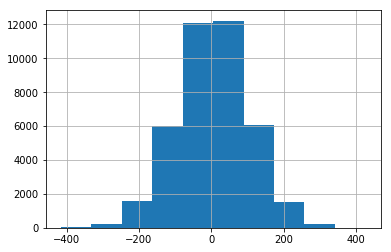

In [19]:
df_other.lines.hist()

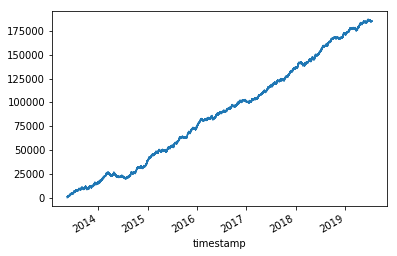

In [20]:
df_other_timed = df_other.set_index('timestamp')
df_other_timed['count'] = df_other_timed.lines.cumsum()
df_other_timed['count'].plot()

## Concatenate all datasets

In [21]:
df = pd.concat([df_jpa, df_jdbc, df_other], ignore_index=True).sort_values(by='timestamp')
df.loc[df.lines > 0, 'additions'] = df.lines
df.loc[df.lines < 0, 'deletions'] = df.lines * -1
df = df.fillna(0).reset_index(drop=True)
df = df[['additions', 'deletions', 'file', 'timestamp']]
df.loc[(df.deletions > 0) & (df.loc[0].timestamp == df.timestamp),'additions'] = df.deletions
df.loc[df.loc[0].timestamp == df.timestamp,'deletions'] = 0
df['additions'] = df.additions.astype(int)
df['deletions'] = df.deletions.astype(int)
df = df.sort_values(by='timestamp', ascending=False)
df.head()

,additions,deletions,file,timestamp
41799,56,0,src/main/java/org/springframework/samples/petc...,2019-07-19 19:16:44
41798,0,62,src/main/java/org/springframework/samples/petc...,2019-07-19 19:16:44
41770,0,117,src/main/java/org/springframework/samples/petc...,2019-07-19 06:09:16
41777,0,0,src/main/java/org/springframework/samples/petc...,2019-07-19 06:09:16
41776,0,46,src/main/java/org/springframework/samples/petc...,2019-07-19 06:09:16



## Truncate data until fixed date

In [22]:
df = df[df.timestamp < pd.Timestamp('2018-01-01')]
df.head()

,additions,deletions,file,timestamp
31486,19,0,src/main/java/org/springframework/samples/petc...,2017-12-31 19:41:29
31485,55,0,src/main/java/org/springframework/samples/petc...,2017-12-30 12:48:20
31484,29,0,src/main/java/org/springframework/samples/petc...,2017-12-30 12:48:20
31461,0,99,src/main/java/org/springframework/samples/petc...,2017-12-30 00:38:54
31467,19,0,src/main/java/org/springframework/samples/petc...,2017-12-30 00:38:54


## Export the data

In [23]:
df.to_csv("datasets/git_log_refactoring.gz", index=None, compression='gzip')

## Check loaded data

In [24]:
df_loaded = pd.read_csv("datasets/git_log_refactoring.gz")
df_loaded.head()

,additions,deletions,file,timestamp
0,19,0,src/main/java/org/springframework/samples/petc...,2017-12-31 19:41:29
1,55,0,src/main/java/org/springframework/samples/petc...,2017-12-30 12:48:20
2,29,0,src/main/java/org/springframework/samples/petc...,2017-12-30 12:48:20
3,0,99,src/main/java/org/springframework/samples/petc...,2017-12-30 00:38:54
4,19,0,src/main/java/org/springframework/samples/petc...,2017-12-30 00:38:54


In [25]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31487 entries, 0 to 31486
Data columns (total 4 columns):
additions    31487 non-null int64
deletions    31487 non-null int64
file         31487 non-null object
timestamp    31487 non-null object
dtypes: int64(2), object(2)
memory usage: 984.0+ KB
